In [1]:
import ee
import folium
from folium import plugins
from tqdm.notebook import tqdm


# Trigger the authentication flow.
ee.Authenticate()
ee.Initialize(project='ee-ahtishamali') # ee-attapitb

In [2]:
# Function to get date range from user
def get_date_range():
    """
    Prompts the user to input a start and end date.

    Returns:
        tuple: start and end date strings in the format 'YYYY-MM-DD'
    """
    #start_date = input("Enter start date (YYYY-MM-DD): ")
    #end_date = input("Enter end date (YYYY-MM-DD): ")
    start_date = "2024-01-01"
    end_date = "2024-01-30"


    return start_date, end_date

# Get date range from user
start_date, end_date = get_date_range()


In [3]:
# Function to print band details
def print_band_details(image_collection, collection_name):
    """
    Prints the band names of the first image in the given image collection.

    Args:
        image_collection (ee.ImageCollection): The image collection to print band names from.
        collection_name (str): The name of the collection.
    """
    try:
        first_image = image_collection.first()
        band_names = first_image.bandNames().getInfo()
        print(f"{collection_name} bands fetched: {band_names}")
    except Exception as e:
        print(f"{collection_name} bands not fetched: {str(e)}")


In [4]:
# Function to resample bands to 10m
def resample_to_10m(image):
    """
    Resamples the bands of the given image to a resolution of 10 meters.

    Args:
        image (ee.Image): The image to resample.

    Returns:
        ee.Image: The resampled image.
    """
    return image.resample('bilinear').reproject(crs='EPSG:32643', scale=10)


In [7]:
# Define the Area of Interest (AOI) - Hafizabad bounding box
# aoi = ee.Geometry.Rectangle([73.685, 31.568, 73.843, 31.713])
aoi = ee.Geometry.Rectangle([74.0455022608441, 31.6239635131339,74.0454876740567, 31.6236938951687]); # [73.71974314045983, 31.67526070389372, 73.7293561775692, 31.68256493364132]

# Load Sentinel-2 Imagery
sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
                .filterBounds(aoi) \
                .filterDate(start_date, end_date) \
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5))  # Filtering clouds

# Fetch and print band details
print_band_details(sentinel2, "Sentinel-2")

# Clip and select bands for Sentinel-2
sentinel2_clipped = sentinel2.map(lambda img: img.clip(aoi))  # All bands


Sentinel-2 bands fetched: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'MSK_CLASSI_OPAQUE', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_SNOW_ICE']


In [8]:

# Debug statements to check if clipping is done correctly
print("Sentinel-2 clipped image count:", sentinel2_clipped.size().getInfo())

# Apply resampling
sentinel2_resampled = sentinel2_clipped.map(resample_to_10m)

# Debug statements to check if resampling is done correctly
print("Sentinel-2 resampled image count:", sentinel2_resampled.size().getInfo())

# Get all band names from Sentinel-2
s2_band_names = sentinel2_resampled.first().bandNames().getInfo()
print("Total Bands:",len(s2_band_names))
print("Sentinel-2 band names:", s2_band_names)


Sentinel-2 clipped image count: 4
Sentinel-2 resampled image count: 4
Total Bands: 26
Sentinel-2 band names: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'MSK_CLASSI_OPAQUE', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_SNOW_ICE']


In [24]:

# Define functions to calculate each index
def calculate_ndvi(image):
    """
    Calculates the NDVI for the given image.

    Args:
        image (ee.Image): The image to calculate NDVI for.

    Returns:
        ee.Image: The image with the NDVI band.
    """
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return ndvi

def calculate_evi(image):
    """
    Calculates the EVI for the given image.

    Args:
        image (ee.Image): The image to calculate EVI for.

    Returns:
        ee.Image: The image with the EVI band.
    """
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4'),
            'BLUE': image.select('B2')
        }).rename('EVI')
    return evi

def calculate_savi(image):
    """
    Calculates the SAVI for the given image.

    Args:
        image (ee.Image): The image to calculate SAVI for.

    Returns:
        ee.Image: The image with the SAVI band.
    """
    savi = image.expression(
        '((NIR - RED) / (NIR + RED + 0.5)) * (1.5)',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4')
        }).rename('SAVI')
    return savi

def calculate_ndre(image):
    """
    Calculates the NDRE for the given image.

    Args:
        image (ee.Image): The image to calculate NDRE for.

    Returns:
        ee.Image: The image with the NDRE band.
    """
    ndre = image.normalizedDifference(['B8', 'B5']).rename('NDRE')
    return ndre

def calculate_ddi(image):
    """
    Calculates the DDI for the given image.

    Args:
        image (ee.Image): The image to calculate DDI for.

    Returns:
        ee.Image: The image with the DDI band.
    """
    ddi = image.normalizedDifference(['B3', 'B5']).rename('DDI')
    return ddi

def calculate_arvi(image):
    """
    Calculates the ARVI for the given image.

    Args:
        image (ee.Image): The image to calculate ARVI for.

    Returns:
        ee.Image: The image with the ARVI band.
    """
    arvi = image.expression(
        '(NIR - (2 * RED - BLUE)) / (NIR + (2 * RED - BLUE))',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4'),
            'BLUE': image.select('B2')
        }).rename('ARVI')
    return arvi

def calculate_gci(image):
    """
    Calculates the GCI for the given image.

    Args:
        image (ee.Image): The image to calculate GCI for.

    Returns:
        ee.Image: The image with the GCI band.
    """
    gci = image.expression(
        '(NIR / GREEN) - 1',
        {
            'NIR': image.select('B8'),
            'GREEN': image.select('B3')
        }).rename('GCI')
    return gci

def calculate_ndwi(image):
    """
    Calculates the NDWI for the given image.

    Args:
        image (ee.Image): The image to calculate NDWI for.

    Returns:
        ee.Image: The image with the NDWI band.
    """
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    return ndwi

def calculate_vari(image):
    """
    Calculates the VARI for the given image.

    Args:
        image (ee.Image): The image to calculate VARI for.

    Returns:
        ee.Image: The image with the VARI band.
    """
    vari = image.expression(
        '(GREEN - RED) / (GREEN + RED - BLUE)',
        {
            'GREEN': image.select('B3'),
            'RED': image.select('B4'),
            'BLUE': image.select('B2')
        }).rename('VARI')
    return vari

def calculate_lai(image):
    """
    Calculates the LAI for the given image.

    Args:
        image (ee.Image): The image to calculate LAI for.

    Returns:
        ee.Image: The image with the LAI band.
    """
    lai = image.expression(
        '3.618 * EVI - 0.118',
        {
            'EVI': calculate_evi(image)
        }).rename('LAI')
    return lai

def calculate_nbr(image):
    """
    Calculates the NBR for the given image.

    Args:
        image (ee.Image): The image to calculate NBR for.

    Returns:
        ee.Image: The image with the NBR band.
    """
    nbr = image.normalizedDifference(['B8', 'B12']).rename('NBR')
    return nbr

def calculate_ndsi(image):
    """
    Calculates the NDSI for the given image.

    Args:
        image (ee.Image): The image to calculate NDSI for.

    Returns:
        ee.Image: The image with the NDSI band.
    """
    ndsi = image.normalizedDifference(['B3', 'B11']).rename('NDSI')
    return ndsi

def calculate_istack(image):
    """
    Calculates a stack of indices (NDVI, NDWI, NDSI) for the given image.

    Args:
        image (ee.Image): The image to calculate the index stack for.

    Returns:
        ee.Image: The image with the index stack.
    """
    ndvi = calculate_ndvi(image)
    ndwi = calculate_ndwi(image)
    ndsi = calculate_ndsi(image)
    istack = ee.Image.cat([ndvi, ndwi, ndsi]).rename(['NDVI', 'NDWI', 'NDSI'])
    return istack

def calculate_rmi(image):
    """
    Calculates the RMI for the given image.

    Args:
        image (ee.Image): The image to calculate RMI for.

    Returns:
        ee.Image: The image with the RMI band.
    """
    rmi = image.expression(
        '(NIR - RED) / (NIR + RED)',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4')
        }).rename('RMI')
    return rmi

def calculate_bri(image):
    """
    Calculates the BRI for the given image.

    Args:
        image (ee.Image): The image to calculate BRI for.

    Returns:
        ee.Image: The image with the BRI band.
    """
    bri = image.expression(
        '(RED + GREEN) / 2',
        {
            'RED': image.select('B4'),
            'GREEN': image.select('B3')
        }).rename('BRI')
    return bri

def calculate_cwsi(image):
    """
    Calculates the CWSI for the given image.

    Args:
        image (ee.Image): The image to calculate CWSI for.

    Returns:
        ee.Image: The image with the CWSI band.
    """
    cwsi = image.expression(
        '(T_surface - T_air) / (T_surface - T_wet)',
        {
            'T_surface': image.select('B11'),
            'T_air': 298,  # Placeholder for air temperature
            'T_wet': 290   # Placeholder for wet bulb temperature
        }).rename('CWSI')
    return cwsi

def calculate_gvmi(image):
    """
    Calculates the GVMI for the given image.

    Args:
        image (ee.Image): The image to calculate GVMI for.

    Returns:
        ee.Image: The image with the GVMI band.
    """
    gvmi = image.expression(
        '(NIR + 0.1) / (SWIR + 0.02)',
        {
            'NIR': image.select('B8'),
            'SWIR': image.select('B11')
        }).rename('GVMI')
    return gvmi

def calculate_lwci(image):
    """
    Calculates the LWCI for the given image.

    Args:
        image (ee.Image): The image to calculate LWCI for.

    Returns:
        ee.Image: The image with the LWCI band.
    """
    lwci = image.expression(
        'NIR / SWIR',
        {
            'NIR': image.select('B8'),
            'SWIR': image.select('B11')
        }).rename('LWCI')
    return lwci

# Function to calculate and visualize indices for each image
def calculate_and_visualize_indices(image_collection, indices, collection_name):
    """
    Calculates and visualizes indices for each image in the given collection.

    Args:
        image_collection (ee.ImageCollection): The image collection to process.
        indices (dict): A dictionary of index calculation functions.
        collection_name (str): The name of the collection.
    """
    for img in tqdm(image_collection.toList(image_collection.size()).getInfo(), desc=f'Calculating indices for {collection_name}'):
        image = ee.Image(img['id']).clip(aoi)
        id_suffix = image.id().getInfo().split('/')[-1]
        for index_name, index_function in indices.items():
            index_image = index_function(image)
            index_min_max = get_min_max(index_image, index_image.bandNames().getInfo())
            index_layer = visualize_image(index_image, index_min_max, index_image.bandNames().getInfo()[0], f"{index_name}_{id_suffix}")
            if index_layer is not None:
                index_layer.add_to(m)




# Function to calculate min-max for visualization
def get_min_max(image, bands):
    """
    Calculates the min and max values for the given bands in the image.

    Args:
        image (ee.Image): The image to calculate min-max for.
        bands (list): The bands to calculate min-max for.

    Returns:
        dict: A dictionary with min and max values for each band.
    """
    min_max = image.reduceRegion(
        reducer=ee.Reducer.minMax(),
        geometry=aoi,
        scale=10,
        maxPixels=1e13
    ).getInfo()
    return {band: (min_max.get(band + '_min', None), min_max.get(band + '_max', None)) for band in bands}




# # Function to visualize the image on the map with image ID suffix
# def visualize_image(image, min_max, bands, name):
#     """
#     Visualizes the given image on a folium map with the specified parameters.

#     Args:
#         image (ee.Image): The image to visualize.
#         min_max (dict): The min and max values for the visualization.
#         band (str): The band to visualize.
#         name (str): The name for the visualization layer.

#     Returns:
#         folium.raster_layers.TileLayer: The folium layer for the visualization.
#     """
#     vis_bands = bands[:3]
#     vis_params = {
#     'min': [float(min_max[band][0]) if min_max[band][0] is not None else 0 for band in vis_bands],
#     'max': [float(min_max[band][1]) if min_max[band][1] is not None else 0 for band in vis_bands],
#     'bands': vis_bands
# }
#     # vis_params = {
#     #     'min': [min_max[band][0] for band in bands],
#     #     'max': [min_max[band][1] for band in bands],
#     #     'bands': vis_bands
#     # }
#     map_id = image.getMapId(vis_params)
#     return folium.raster_layers.TileLayer(
#         tiles=map_id['tile_fetcher'].url_format,
#         attr='Map Data &copy; <a href="https://earthengine.google.com">Google Earth Engine</a>',
#         name=name,
#         overlay=True
#     )


# # Function to visualize and export image to Google Drive
# def export_image_to_drive(image, min_max, bands, filename, folder):
#   vis_bands = bands[:3]
#   vis_params = {
#       'bands': vis_bands,
#       'min': [min_max[band][0] for band in bands],
#       'max': [min_max[band][1] for band in bands],
#       'palette': ['blue', 'green', 'red']
#   }
#   image = image.select(vis_bands).toFloat()  # Cast band to float before export
#   task = ee.batch.Export.image.toDrive(
#       image=image,
#       description=filename,
#       folder=folder,
#       fileNamePrefix=filename,
#       region=aoi,
#       scale=10,
#       crs='EPSG:4326'
#   )
#   task.start()

def visualize_image(image, min_max, bands, name):
    # vis_params = {  # Modified: Only visualize the first 3 bands
    #     'min': [min_max[band][0] for band in bands],
    #     'max': [min_max[band][1] for band in bands],
    #     'bands': bands
    # }

    #     vis_bands = bands[:3]
    vis_params = {
    'min': [float(min_max[band][0]) if min_max[band][0] is not None else 0 for band in bands],
    'max': [float(min_max[band][1]) if min_max[band][1] is not None else 0 for band in bands],
    'bands': bands
}
    map_id = image.getMapId(vis_params)
    return folium.raster_layers.TileLayer(
        tiles=map_id['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com">Google Earth Engine</a>',
        name=name,
        overlay=True
    )

# Function to visualize and export image to Google Drive
def export_image_to_drive(image, bands, filename, folder):  # Modified: Remove min_max parameter
    image = image.select(bands).toFloat()  # Cast band to float before export
    task = ee.batch.Export.image.toDrive(  # Modified: Simplified export function
        image=image.select(bands),  # Ensure all bands are exported
        description=filename,
        folder=folder,
        fileNamePrefix=filename,
        region=aoi,
        scale=10,
        crs='EPSG:4326'
    )
    task.start()


In [25]:
# Create a folium map
map_center = [31.640, 73.765]  # Center of the AOI
m = folium.Map(location=map_center, zoom_start=12)


In [26]:
import pandas as pd
# Extract band values from each image and store in a DataFrame
def extract_band_values(image, bands):
    reduction = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=10,
        maxPixels=1e13
    ).getInfo()
    band_values = {band: reduction.get(band) for band in bands if reduction.get(band) is not None}
    band_values['date'] = image.date().format('YYYY-MM-dd').getInfo()
    return band_values
drive_folder = "Last Sentinel"

data = []
for img in tqdm(sentinel2_resampled.toList(sentinel2_resampled.size()).getInfo(), desc='Processing Sentinel-2 images'):
    image = ee.Image(img['id'])
    id_suffix = image.id().getInfo().split('/')[-1]
    band_values = extract_band_values(image, s2_band_names)
    data.append(band_values)
    min_max = get_min_max(image, s2_band_names[:3])
    image_layer = visualize_image(image, min_max, s2_band_names[:3], f"Sentinel-2_{id_suffix}")
    if image_layer is not None:
        image_layer.add_to(m)
    image_name = f"Sentinel-2_{id_suffix}.tif"
    export_image_to_drive(image, s2_band_names, image_name, drive_folder)

# Create a DataFrame from the extracted data and export to CSV
# df = pd.DataFrame(data)
# file_name = "sentinel2_data.csv"
# df.to_csv(file_name, index = False)
# print(f"Data saved to {file_name}")

# # Display the map
# m

Processing Sentinel-2 images:   0%|          | 0/4 [00:00<?, ?it/s]

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1760, 'height': 1615, 'count': 23, 'crs': CRS.from_epsg(4326), 'transform': Affine(8.983152841195215e-05, 0.0, 73.68494000060264,
       0.0, -8.983152841195215e-05, 31.713044812214644)}
           x          y                                              value
0  73.684985  31.713000  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
1  73.684985  31.712910  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
2  73.684985  31.712820  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
3  73.684985  31.712730  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
4  73.684985  31.712641  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...


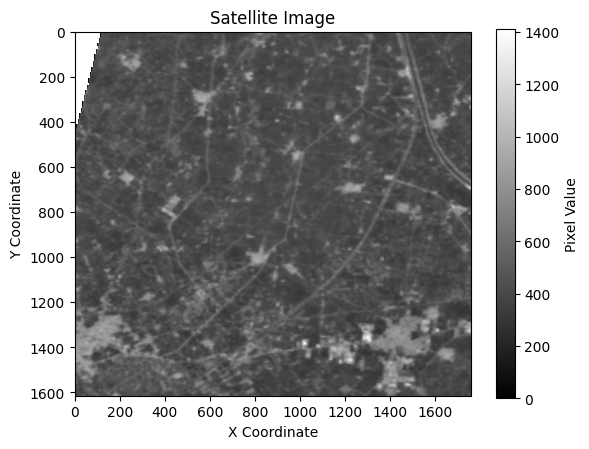

In [ ]:
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Path to the GeoTIFF file
file_path = 'Sentinel-2_20240127T054101_20240127T054103_T43SCR.tif'

# Open the GeoTIFF file
with rasterio.open(file_path) as src:
    # Read the entire dataset
    array = src.read()

    # Get metadata
    metadata = src.meta

    # Get coordinates and pixel values
    coords = []
    values = []
    for i in range(src.width):
        for j in range(src.height):
            # Get pixel value
            value = array[:, j, i]  # all bands for the pixel
            values.append(value)

            # Get coordinates
            x, y = src.xy(j, i)
            coords.append((x, y))

# Convert lists to numpy arrays for further processing
coords = np.array(coords)
values = np.array(values)

# Display the metadata
print(metadata)

# Create a DataFrame for better visualization and analysis
df = pd.DataFrame({
    'x': coords[:, 0],
    'y': coords[:, 1],
    'value': values.tolist()
})

# Display first few rows of the DataFrame
print(df.head())

# Plot the image (assuming single band for simplicity)
plt.imshow(array[0], cmap='gray')
plt.title('Satellite Image')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.colorbar(label='Pixel Value')
plt.show()


In [ ]:
import rasterio
import numpy as np

# Path to your TIFF file
tif_path = 'Sentinel-2_20240127T054101_20240127T054103_T43SCR.tif'

# Open the TIFF file
with rasterio.open(tif_path) as dataset:
    # Number of bands
    num_bands = dataset.count
    print(f"Number of bands: {num_bands}")

    # Extract band values and pixel values
    band_data = []
    for i in range(1, num_bands + 1):
        band = dataset.read(i)
        band_data.append(band)
        print(f"Band {i} data:")
        print(band)

    # Convert the list to a 3D numpy array if needed
    all_data = np.stack(band_data, axis=0)
    print("All data shape (bands, height, width):", all_data.shape)


Number of bands: 23
Band 1 data:
[[ nan  nan  nan ... 391. 398. 398.]
 [ nan  nan  nan ... 391. 398. 398.]
 [ nan  nan  nan ... 391. 398. 398.]
 ...
 [394. 394. 394. ... 355. 355. 355.]
 [412. 412. 412. ... 355. 355. 355.]
 [412. 412. 412. ... 345. 345. 345.]]
Band 2 data:
[[ nan  nan  nan ... 457. 357. 332.]
 [ nan  nan  nan ... 384. 342. 344.]
 [ nan  nan  nan ... 367. 374. 393.]
 ...
 [348. 316. 352. ... 328. 378. 469.]
 [343. 382. 479. ... 312. 342. 453.]
 [500. 468. 425. ... 321. 344. 369.]]
Band 3 data:
[[ nan  nan  nan ... 772. 600. 630.]
 [ nan  nan  nan ... 710. 620. 600.]
 [ nan  nan  nan ... 648. 634. 618.]
 ...
 [617. 568. 592. ... 580. 679. 710.]
 [610. 638. 633. ... 584. 625. 711.]
 [696. 701. 696. ... 580. 602. 652.]]
Band 4 data:
[[ nan  nan  nan ... 461. 329. 305.]
 [ nan  nan  nan ... 429. 304. 327.]
 [ nan  nan  nan ... 380. 339. 348.]
 ...
 [364. 336. 350. ... 352. 448. 517.]
 [394. 475. 570. ... 322. 346. 488.]
 [587. 574. 530. ... 326. 310. 396.]]
Band 5 data:
[[ 

In [ ]:
import rasterio
import numpy as np
import pandas as pd

# Path to your TIFF file
tif_path = 'Sentinel-2_20240127T054101_20240127T054103_T43SCR.tif.tif'

# Open the TIFF file
with rasterio.open(tif_path) as dataset:
    # Number of bands
    num_bands = dataset.count
    print(f"Number of bands: {num_bands}")

    # Extract band values and pixel values
    band_data = []
    for i in range(1, num_bands + 1):
        band = dataset.read(i)
        band_data.append(band)

    # Convert the list to a 3D numpy array
    all_data = np.stack(band_data, axis=0)
    print("All data shape (bands, height, width):", all_data.shape)

    # Flatten the array to (num_pixels, num_bands)
    flattened_data = all_data.reshape(num_bands, -1).T

    # Get coordinates for each pixel
    rows, cols = np.indices(dataset.shape)
    x_coords, y_coords = rasterio.transform.xy(dataset.transform, rows, cols)
    x_coords = np.array(x_coords).flatten()
    y_coords = np.array(y_coords).flatten()

    # Create a DataFrame
    data = {'x': x_coords, 'y': y_coords}
    for i in range(num_bands):
        data[f'Band_{i+1}'] = flattened_data[:, i]

    df = pd.DataFrame(data)

    # Save to CSV
    df.to_csv('123.csv', index=False)

print("Data extraction and saving complete.")


Number of bands: 26
All data shape (bands, height, width): (26, 82, 108)
Data extraction and saving complete.


In [ ]:
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Path to your TIFF file
tif_path = 'Sentinel-2_20240127T054101_20240127T054103_T43SCR.tif'

# Open the TIFF file
with rasterio.open(tif_path) as dataset:
    # Number of bands
    num_bands = dataset.count
    print(f"Number of bands: {num_bands}")

    # Extract band values and pixel values
    band_data = []
    for i in range(1, num_bands + 1):
        band = dataset.read(i)
        band_data.append(band)

    # Convert the list to a 3D numpy array
    all_data = np.stack(band_data, axis=0)
    print("All data shape (bands, height, width):", all_data.shape)

    # Flatten the array to (num_pixels, num_bands)
    flattened_data = all_data.reshape(num_bands, -1).T

    # Get coordinates for each pixel
    rows, cols = np.indices(dataset.shape)
    x_coords, y_coords = rasterio.transform.xy(dataset.transform, rows, cols)
    x_coords = np.array(x_coords).flatten()
    y_coords = np.array(y_coords).flatten()

    # Create a DataFrame
    data = {'x': x_coords, 'y': y_coords}
    for i in range(num_bands):
        data[f'Band_{i+1}'] = flattened_data[:, i]

    df = pd.DataFrame(data)

    # Convert to a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y))

    # Save to a file
    gdf.to_file('pixel_values_with_coordinates.geojson', driver='GeoJSON')

print("Data extraction and saving complete.")


Number of bands: 23
All data shape (bands, height, width): (23, 1615, 1760)
Data extraction and saving complete.


KeyboardInterrupt: 

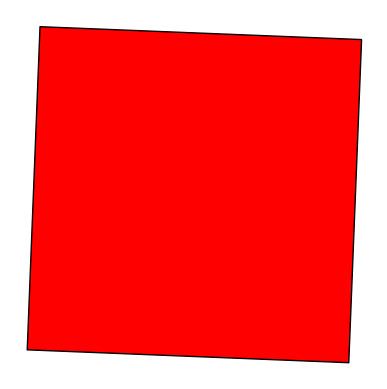

In [ ]:
import pandas as pd
import os
from shapely import wkt
import geopandas as gpd
import matplotlib.pyplot as plt

# Step 1: Read the CSV file
file_path = 'farm_boundary_csv.csv'
df = pd.read_csv(file_path)

# Step 2: Find unique words in the 'crop_type' column
unique_crop_types = df['crop_type'].unique()

# Step 3: Create unique folders based on unique words
output_dir = 'crop_images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for crop_type in unique_crop_types:
    crop_dir = os.path.join(output_dir, crop_type)
    if not os.path.exists(crop_dir):
        os.makedirs(crop_dir)

# Step 4 and 5: Process each multipolygon and save images
for index, row in df.iterrows():
    # Parse the WKT geometry
    multipolygon = wkt.loads(row['WKT'])

    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame({'geometry': [multipolygon]}, crs="EPSG:4326")

    # Define the output file path
    crop_type = row['crop_type']
    crop_dir = os.path.join(output_dir, crop_type)
    output_file = os.path.join(crop_dir, f'polygon_{index}.png')

    # Plot the multipolygon and save the image
    fig, ax = plt.subplots()
    gdf.plot(ax=ax, color='red', edgecolor='black')
    plt.axis('off')
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)

print("Images have been saved in the 'crop_images' directory.")


In [ ]:
import pandas as pd
import os
from shapely import wkt
import ee
import requests

# Initialize the Earth Engine API
ee.Initialize()

# Read the CSV file
file_path = '/mnt/data/farm_boundary_csv.csv'
df = pd.read_csv(file_path)

# Find unique crop types
unique_crop_types = df['crop_type'].unique()

# Create folders for each unique crop type
output_base_dir = 'crop_images'
os.makedirs(output_base_dir, exist_ok=True)

for crop_type in unique_crop_types:
    crop_dir = os.path.join(output_base_dir, crop_type)
    os.makedirs(crop_dir, exist_ok=True)

# Function to fetch and save image
def fetch_and_save_image(polygon, crop_type, output_path):
    # Define the area of interest (AOI)
    aoi = ee.Geometry.Polygon(polygon.exterior.coords)

    # Select a satellite image collection (e.g., Sentinel-2)
    collection = ee.ImageCollection('COPERNICUS/S2') \
        .filterBounds(aoi) \
        .filterDate('2023-01-01', '2023-12-31') \
        .sort('CLOUDY_PIXEL_PERCENTAGE') \
        .first()

    # Define visualization parameters
    vis_params = {
        'bands': ['B4', 'B3', 'B2'],  # RGB
        'min': 0,
        'max': 3000,
    }

    # Get the URL of the image
    url = collection.getThumbURL({'region': aoi, **vis_params, 'format': 'png'})

    # Download the image
    response = requests.get(url)
    with open(output_path, 'wb') as f:
        f.write(response.content)

# Iterate over each row in the dataframe and process polygons
for index, row in df.iterrows():
    crop_type = row['crop_type']
    wkt_polygon = row['WKT']
    polygon = wkt.loads(wkt_polygon)

    # Define the output path
    output_path = os.path.join(output_base_dir, crop_type, f'{index}.png')

    # Fetch and save the image
    fetch_and_save_image(polygon, crop_type, output_path)
